# BottomTrendFollow Researches

# Profit Factor Analysis Summary

Obtain results with naive transaction that no adjusting lot, leverage, and trading strategy.
Analyze results with profit factor and timeframe

まずはナイーブな取引、つまりロットもレバレッジも取引戦略も調整していない取引の結果を集計、計算する。
そしてプロフィットファクターと時間足についても調査する。

In [1]:
%matplotlib inline
import research_kit as rk

rk.pd.set_option("display.max_columns", 250)
rk.pd.set_option("display.max_rows", 250)
import warnings
warnings.filterwarnings('ignore')

bot = rk.BottomTrendFollow(db_client=rk.mysql_client, exchange_client=rk.bitmex_exchange_client, is_backtest=True)

def show_bottom_trend_follow_params(bot):
    rk.pprint(bot.combined_params)
    
show_bottom_trend_follow_params(bot)

downloading BTC/USD data on bitmex
downloading 2019-12-30 14:49:30 ~ 2019-12-30 15:14:54.723920 data
100.0% completed
{'bot_name': 'bottom_trend_follow',
 'bottom_trend_tick': 12,
 'close_position_on_do_nothing': True,
 'inverse_trading': False,
 'middle_trend_tick': 6,
 'timeframe': 60,
 'top_trend_tick': 3}


In [2]:
def generate_transaction_log(bot, close_position_on_do_nothing=True, inverse_trading=False):
    backtest_start_time = rk.datetime(2019,9,30,11,49)
    backtest_end_time = rk.datetime(2019,12,29,11,49)
    
    ohlcv_df_1min = rk.dataset_manager.get_ohlcv(start_time=backtest_start_time, end_time=backtest_end_time)
    print("dataset size:" + str(len(ohlcv_df_1min)))
    
    timeframe_params = [60,30,10,1]
    bottom_trend_tick_params = [5,10,15,20,25,30,35,40,45,50]
    middle_trend_tick_params = [3,5,7,9,12,15,18,21,24,27,30]
    top_trend_tick_params = [1,2,3,4,5,6,7,8]
    
    calc_start_time = rk.datetime.now()
    
    for timeframe in timeframe_params:
        print("timeframe=>" + str(timeframe))
        for bottom_trend_tick in bottom_trend_tick_params:
            for middle_trend_tick in middle_trend_tick_params:           
                for top_trend_tick in top_trend_tick_params:
                    if bottom_trend_tick <= middle_trend_tick or middle_trend_tick <= top_trend_tick:
                        continue
                        
                    default_params = {
                        "bot_name": bot.bot_name,
                        "close_position_on_do_nothing": close_position_on_do_nothing,
                        "inverse_trading": inverse_trading,
                        "timeframe": int(timeframe)
                    }
                    
                    specific_params = {
                        "bottom_trend_tick": int(bottom_trend_tick),
                        "middle_trend_tick": int(middle_trend_tick),
                        "top_trend_tick": int(top_trend_tick)
                    }
                    
                    bot.reset_backtest_result_with_params(default_params, specific_params)
                    before_run = rk.datetime.now()
                    bot.run(ohlcv_df=ohlcv_df_1min[::timeframe], backtest_start_time=backtest_start_time,
                           backtest_end_time=backtest_end_time)
                    print("bottom_trend_tick=>" + str(bottom_trend_tick) +\
                          " midle_trend_tick=>" + str(middle_trend_tick) +\
                          " top_trend_tick=>" + str(top_trend_tick) + " time:" + str(rk.datetime.now() - before_run))
        bot.bulk_insert()
    print("total processing time:" + str(rk.datetime.now() - calc_start_time))

#generate_transaction_log(bot)
# it takes more than 4hours to calculate all wuth insert after getting transaction log before commit "optimize metrics calc"

#generate_transaction_log(bot, inverse_trading=False)
#generate_transaction_log(bot, inverse_trading=True)
# it takes 1hour + 10 min to caluculate the first one after update.
# it takes 1hour + 40 min to caluculate the second one after update

In [3]:
def get_joined_params_and_summary(bot):
    backtest_management = bot.backtest_management_table()
    backtest_summary = rk.BacktestSummary()
    
    query_management = "SELECT * FROM " + bot.backtest_management_table_name + ";"
    query_summary = "SELECT * FROM backtest_summary;"
    
    backtest_management_df = rk.mysql_client.exec_sql(query_management)
    backtest_summary_df = rk.mysql_client.exec_sql(query_summary)
    
    merged_backtest_results = rk.pd.merge(backtest_management_df, backtest_summary_df, left_on="backtest_summary_id", right_on="id")
    return merged_backtest_results
    
merged_results = get_joined_params_and_summary(bot)
merged_results.style.set_table_styles([dict(selector="th",props=[('max-width', '50px')])])

normal_results = merged_results.query("inverse_trading == False")
inversed_results = merged_results.query("inverse_trading == True")

In [4]:
def profit_factor_analysis(df, figure_title):
    columns_picked_up = df.sort_values("profit_factor", ascending=False).loc[:,[
        "timeframe",
        "bottom_trend_tick",
        "middle_trend_tick",
        "top_trend_tick",
        "profit_factor"
    ]]
    
    bins=100
    
    timeframe_params = [60,30,10,1]
    
    fig_profit_factor_histogram = rk.plt.figure()
    fig_profit_factor_histogram.suptitle(figure_title, fontsize=16, y=1.01)
    #fig_profit_factor_histogram.subplots_adjust(wspace=0.4, hspace=0.6)
    profit_factor_histogram_all = fig_profit_factor_histogram.add_subplot(len(timeframe_params)+1,1,1)
    profit_factor_histogram_all.hist(df.profit_factor, bins=100)
    profit_factor_histogram_all.set_title("profit factor distribution for all rows")
    profit_factor_histogram_all.set_xlabel("profit factor")
    profit_factor_histogram_all.set_ylabel("freq")
    
    profit_factor_histogram_all.set_xlim(0.5,1.7)
    
    for i, timeframe in enumerate(timeframe_params):
        profit_factor_histogram = fig_profit_factor_histogram.add_subplot(len(timeframe_params) + 1,1, 2 + i)
        profit_factor_histogram.hist(columns_picked_up.query("timeframe==" + str(timeframe)).profit_factor, bins=bins)
        profit_factor_histogram.set_title("profit factor distribution for timeframe=" + str(timeframe))
        profit_factor_histogram.set_xlabel("profit factor")
        profit_factor_histogram.set_ylabel("freq")
        
        profit_factor_histogram.set_xlim(0.5,1.7)
        
    fig_profit_factor_histogram.tight_layout()
    
rk.plt.rcParams['figure.figsize'] = (10.0, 10.0)

In [5]:
def visualize_timeframe_entry_profit_relation(df, figure_title, inversed=False):
    rk.plt.rcParams['figure.figsize'] = (10.0, 10.0)
    title = "timeframe entry and profit total profit"
    if inversed:
        title += " inversed"
    
    figure_timeframe_entry_profit = rk.plt.figure()
    figure_timeframe_entry_profit.suptitle(figure_title, fontsize=16, y=1.01)
    graph1 = figure_timeframe_entry_profit.add_subplot(1,1,1)
    graph1.set_title(title)
    graph1.set_xlabel("total_entry")
    graph1.set_ylabel("total return")

    for t in [60,30,10,1]:
        graph1.scatter(df[df.timeframe == t].total_entry,
                       df[df.timeframe == t].total_return,
                   alpha=0.5,linewidths="1", label="timeframe:" + str(t))
        graph1.legend()
    
    figure_timeframe_entry_profit.tight_layout()

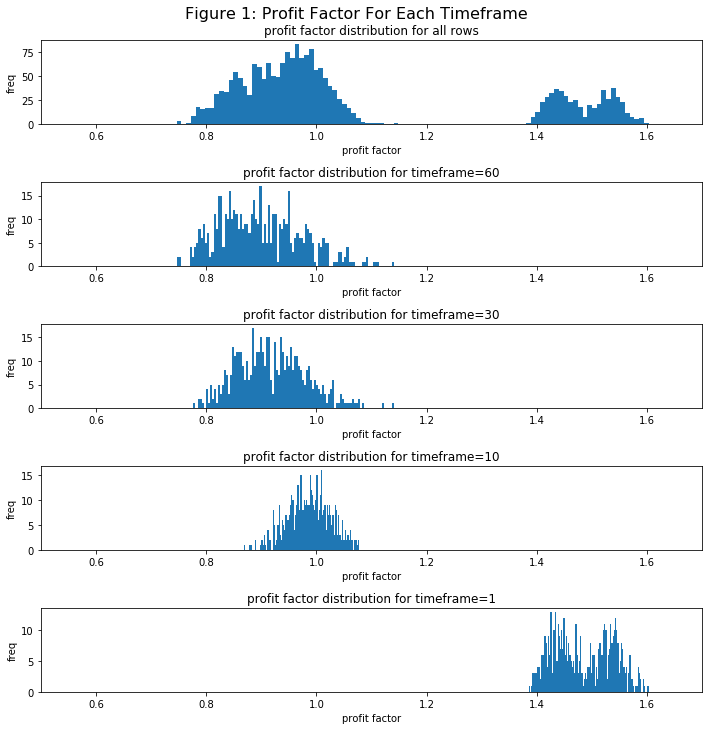

In [6]:
profit_factor_analysis(normal_results, "Figure 1: Profit Factor For Each Timeframe")

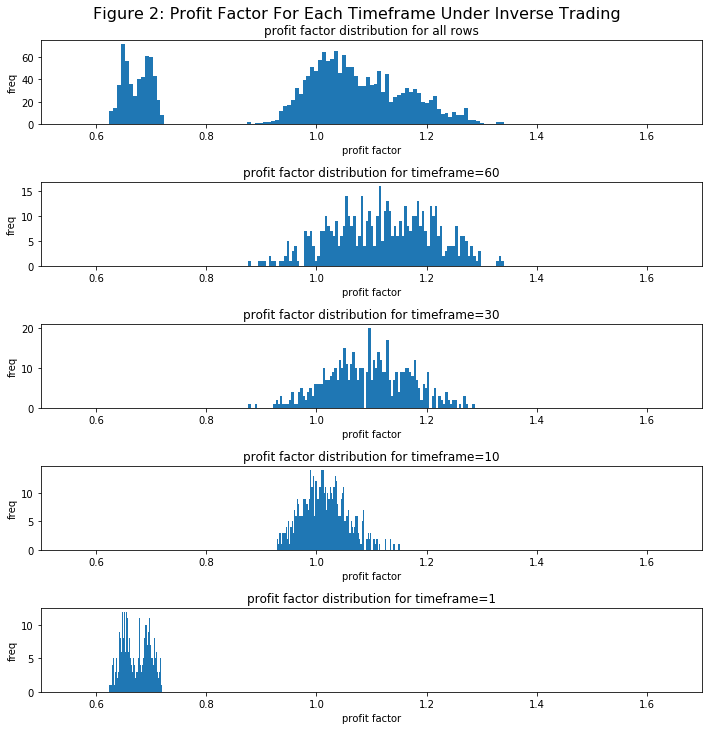

In [7]:
profit_factor_analysis(inversed_results, "Figure 2: Profit Factor For Each Timeframe Under Inverse Trading")

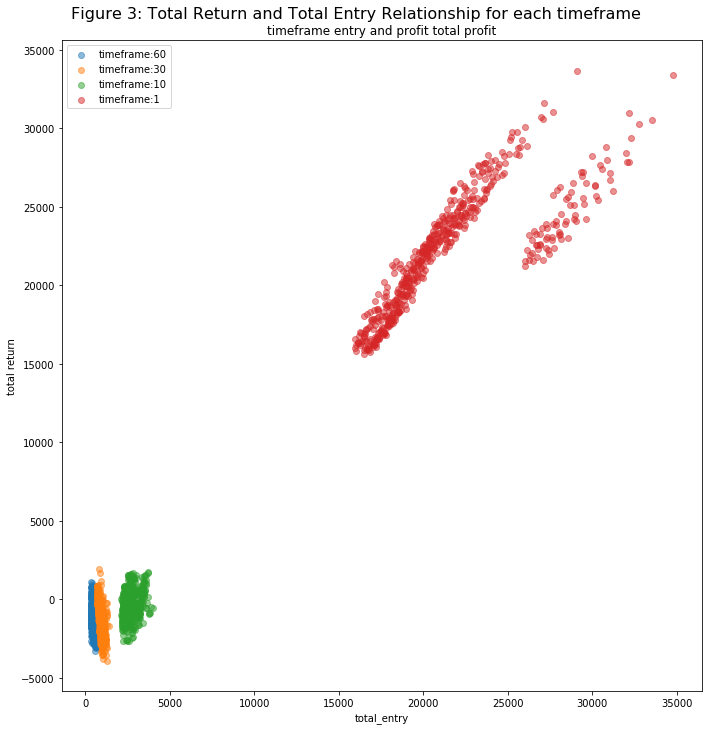

In [8]:
visualize_timeframe_entry_profit_relation(normal_results,
    "Figure 3: Total Return and Total Entry Relationship for each timeframe",
    inversed=False)

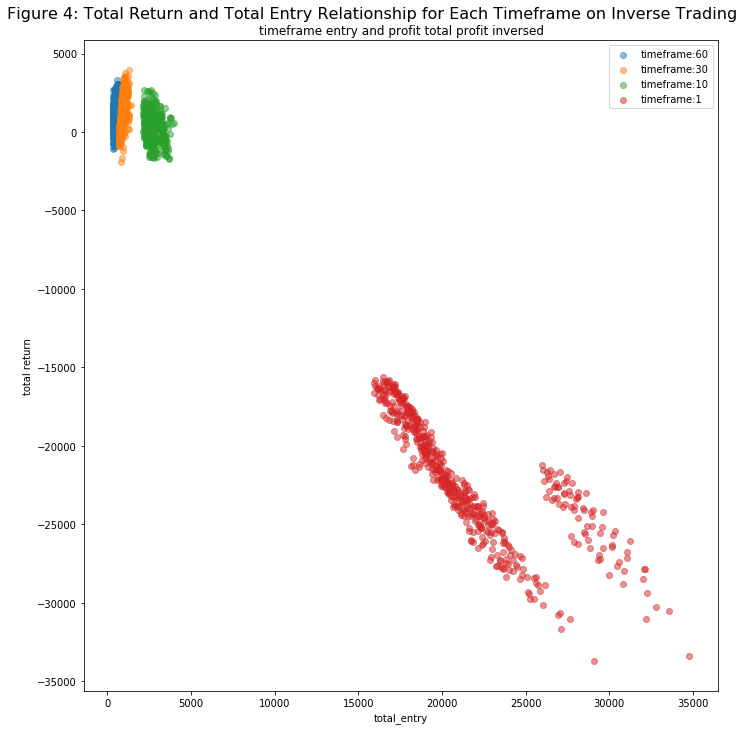

In [ ]:
visualize_timeframe_entry_profit_relation(inversed_results,
    "Figure 4: Total Return and Total Entry Relationship for Each Timeframe on Inverse Trading",
    inversed=True)

# Profit Factor Analysis Summary

## Histograms and Distributions

As you see, Figure 1 hisograms show tendency that the shorter timeframe, the better profit factor.
However, it may be implied that the result caused by just a overfitting and such parameters with short timeframe
would work not well in real environment.

In this part, record the average rank for each timeframe and parameter.
The calculation order is bottom -> middle -> top, because the shorter tick has larger effect to the result.
Hence the result of calculation regard as a representative and optimal parameter for each timeframe.

## Scatterplots for Each Timeframe

Figure3 show that there are clusters for each timeframe clearly.
From this figure, we can see that for the shorter timeframe, gain the better profit.
Especially in timeframe=1, there are 2 clusters inside. I'll discuss the difference between 2 clusters in later part.
Furthermore, the entry time is highly correlated with the profit.

Figure4 indicate that inverse trading mode works well.

After that, simulate the investment result 100,000 times using bootstrap method with these representative parameters,
then check the investment simulation result of average, mode, median and percentile.


## Histograms and Distributions(Ja)

Figure1を見ると、きれいな双峰分布になっていることが見て取れる。
続いてtimeframe別のグラフを見ていくと、timeframeが小さくなっていくにつれてプロフィットファクターが大きくなっていることがわかる。
だがこの傾向があまりに明白であることと、timeframe、すなわち時間足が短くなればなるほど良い結果が得られることから、
これらのパラメータが過剰にデータセットに適合していて、本番環境ではうまくいかない可能性がある。

Figure2を見ると、Figure1とプロフィットファクターが1の箇所で線対称なグラフになっている。
続いてFigure2の2つ目のグラフを見ていくと、timeframeが60の時に最も期待プロフィットファクターが高くなっている。

## Scatterplots for Each Timeframe

Figre3はx軸にtotal_entryを、y軸にtotal_profitを設定している。
これを見ると、各timeframeごとに明確にクラスターを形成していることがわかる。
timeframeが短ければ短いほど総利益が高まること、特にtimeframe=1のときにはその中で明確に別れる2つのクラスターが存在すること、
そしてそのbotの総エントリー回数と総利益に明確な相関が存在することを示している。
このtimeframe=1のときの2つのクラスターの違いについては今後明らかにする。

Figure4を見るとFigure3とは真逆の結果が得られている。これはinverse tradingがうまく働いていることを示している。


# Find Optimal Parameters

Subsequently, find optimal parameters.

In the first place, record average ranking for each parameters.
Larger ticks are tend to be more influence the result of trading, therefore, calculate the ranking ordered by bottom -> middle -> top.
Finally regard these optimal paramaters as the representative paramaters.

続いてはこの中から最適なパラメータを探索する。

まず各timeframeごとに、それぞれのパラメーターに対して平均的な順位を記録する。
結果への影響力は、短期的な価格変動の効果を受けにくい順に大きいため、bottom -> middle -> topの順で平均的な順位を計算する。
その中で得られた最適なパラメータを各タイムフレームの代表的なパラメーターとする。

In [ ]:
def find_best_ranking_parameter(sorted_df_in_need_with_timeframe, tick_params,
                                bottom_trend_tick=None, middle_trend_tick=None, verbose=False):
    optimal_tick = 0
    max_tick_ranking = 0
    
    # tick optimize detection
    if bottom_trend_tick is None and middle_trend_tick is None:
        base_query = "bottom_trend_tick == "        
                
    elif bottom_trend_tick is not None and middle_trend_tick is None:
        base_query = "bottom_trend_tick == " + str(bottom_trend_tick) + " and middle_trend_tick == "
            
    elif bottom_trend_tick is not None and middle_trend_tick is not None:
        base_query = "bottom_trend_tick == " + str(bottom_trend_tick) + " and middle_trend_tick ==" +\
                    str(middle_trend_tick) + " and top_trend_tick == "
        
    return get_max_ranking_tick(sorted_df_in_need_with_timeframe, base_query, tick_params, verbose=verbose)

def get_max_ranking_tick(sorted_df_in_need_with_timeframe, base_query, tick_params, verbose=False):
    max_tick_ranking = 0
    optimal_tick = 0
    
    for tick in tick_params:
        df = sorted_df_in_need_with_timeframe.query(base_query + str(tick))
                    
        denominator = len(df)
        numerator = df.index.values.sum()
            
        average_ranking = numerator/denominator
        if verbose is True:
            print("denominator => " + str(denominator) + " numerator => " + str(numerator) + " tick => " + str(tick) +\
              " average ranking => " + str(average_ranking))
            
        if average_ranking < max_tick_ranking or max_tick_ranking == 0:
            max_tick_ranking = average_ranking
            optimal_tick = tick
            
    return optimal_tick
    

def find_optimal_parameters_by_ranking(df, verbose=False):
    sorted_df_in_need = df[[
        "timeframe",
        "bottom_trend_tick",
        "middle_trend_tick",
        "top_trend_tick",
        "profit_factor"]
    ].sort_values("profit_factor", ascending=False)
    
    timeframe_params = [60,30,10,1]
    bottom_trend_tick_params = [5,10,15,20,25,30,35,40,45,50]
    middle_trend_tick_params = [3,5,7,9,12,15,18,21,24,27,30]
    top_trend_tick_params = [1,2,3,4,5,6,7,8]
    
    for timeframe in timeframe_params:
        print("calc optimal parameters for timeframe:" + str(timeframe))
        sorted_df_in_need_with_timeframe = sorted_df_in_need.query("timeframe ==" + str(timeframe))
        if verbose:
            print("bottom")
        optimal_bottom = find_best_ranking_parameter(sorted_df_in_need_with_timeframe,
            bottom_trend_tick_params, verbose=verbose)
        if verbose:
            print("middle with bottom => " + str(optimal_bottom) )
        optimal_middle = find_best_ranking_parameter(sorted_df_in_need_with_timeframe,
            middle_trend_tick_params, bottom_trend_tick=optimal_bottom, verbose=verbose)
        if verbose:
            print("top with bottom => " + str(optimal_bottom) + " middle => " + str(optimal_middle))
        optimal_top = find_best_ranking_parameter(sorted_df_in_need_with_timeframe,
            top_trend_tick_params, bottom_trend_tick=optimal_bottom, middle_trend_tick=optimal_middle, verbose=verbose)
        
        print("optimal bottom => " + str(optimal_bottom) + " middle => " +\
              str(optimal_middle) + "top => " + str(optimal_top))            

In [ ]:
find_optimal_parameters_by_ranking(normal_results, verbose=False)

calc optimal parameters for timeframe:60
optimal bottom => 5 middle => 3top => 2
calc optimal parameters for timeframe:30
optimal bottom => 5 middle => 3top => 1
calc optimal parameters for timeframe:10
optimal bottom => 5 middle => 3top => 1
calc optimal parameters for timeframe:1
optimal bottom => 5 middle => 3top => 1


# Find Optimal Parameters Summary

The result shows that bottom=>5, middle=>3, top=>1 is the best combination for all timeframe except for timeframe=60.
However, timeframe=60 is no more important than shorter timeframe, so it's ignorable.
From now, discuss with expected optimal hyperparamaters timeframe=>1, bottom=>5, middle=>3, top=>1 and focus on details under timeframe=1.

timeframe=60を除いたすべての時間軸に対してbottom=>5, middle=>3, top=>1が最適であるという結果が得られた。
timeframe=60は、より短い時間足に比べてそこまで重要ではないので無視する。
ここまでで時間足が1, bottomが5, middleが3, topが1の場合が最適であることが予想される。
ここからはまず、この時間足について詳細に検討する。

In [ ]:
def visualize_timeframe1_clusters_with_xy(df, figure_title, x_axis,y_axis):
    rk.plt.rcParams['figure.figsize'] = (5.0, 5.0)
    figure_timeframe1_cluster_all = rk.plt.figure()
    figure_timeframe1_cluster_all.suptitle(figure_title, fontsize=16, y=1.01)
    
    graph1 = figure_timeframe1_cluster_all.add_subplot(1,1,1)
    graph1.set_title("clustering in timeframe 1")
    graph1.set_xlabel(x_axis)
    graph1.set_ylabel(y_axis)
    graph1.scatter(df[df.timeframe == 1][x_axis],
               df[df.timeframe == 1][y_axis],
               alpha=0.5,linewidths="1", label="timeframe:1", color="r")
    
    figure_timeframe1_cluster_all.tight_layout()
    figure_timeframe1_cluster_all.show()


def visualize_timeframe1_clusters_with_xy_for_each_param(df, figure_title, x_axis, y_axis):
    rk.plt.rcParams['figure.figsize'] = (20.0, 20.0)
    figure_timeframe1_cluster_for_each_param = rk.plt.figure()
    figure_timeframe1_cluster_for_each_param.suptitle(figure_title, fontsize=16, y=1.01)
    
    bottom_trend_tick_params = [5,10,15,20,25,30,35,40,45,50]
    middle_trend_tick_params = [3,5,7,9,12,15,18,21,24,27,30]
    top_trend_tick_params = [1,2,3,4,5,6,7,8]
    
    trend_tick_params = {
        "bottom_trend_tick": bottom_trend_tick_params,
        "middle_trend_tick": middle_trend_tick_params,
        "top_trend_tick": top_trend_tick_params
    }
    
    i = 1
    
    for trend, tick_params in trend_tick_params.items():
        graph = figure_timeframe1_cluster_for_each_param.add_subplot(3,1,i)
        graph.set_title("clustering in timeframe 1 with " + trend)
        graph.set_xlabel(x_axis)
        graph.set_ylabel(y_axis)
        for tick_param in tick_params:
            graph.scatter(df[(df.timeframe == 1) & (df[trend] == tick_param)][x_axis],
                          df[(df.timeframe == 1) & (df[trend] == tick_param)][y_axis],
                          alpha=0.5,linewidths="1", label=trend +":" + str(tick_param),
                          color=(tick_param/rk.np.max(tick_params),0,1-tick_param/rk.np.max(tick_params)))
            graph.legend()
        i += 1
            
    #print(df.head(10))
    #print(df.tail(10))
    
    figure_timeframe1_cluster_for_each_param.tight_layout()
    figure_timeframe1_cluster_for_each_param.show()

In [ ]:
def pickup_top_tick_with_xy(df, figure_title, pick_up_array, x_axis, y_axis, separate=False):
    figure_top = rk.plt.figure()
    figure_top.suptitle(figure_title, fontsize=16, y=1.01)
    
    top_trend_tick_params = [1,2,3,4,5,6,7,8]
    
    picked_df_array = []
    for tick_param in pick_up_array:
        picked_df_array.append(df[(df.timeframe == 1) & (df["top_trend_tick"] == tick_param)])
        
    picked_df = rk.pd.concat(picked_df_array)
    rk.plt.rcParams['figure.figsize'] = (20.0, 20.0)
    
    linear_model = rk.linear_model.LinearRegression()
    
    for i, tick_param in enumerate(pick_up_array):
        if separate:
            graph = figure_top.add_subplot(len(pick_up_array), 1, i+1)
        else:
            graph = figure_top.add_subplot(1, 1, 1)
            rk.plt.rcParams['figure.figsize'] = (20.0, 6.66*(len(pick_up_array)))
            
        x = picked_df[picked_df["top_trend_tick"] == tick_param][x_axis]
        y = picked_df[picked_df["top_trend_tick"] == tick_param][y_axis]
        linear_model.fit(x.values.reshape(-1,1),y.values.reshape(-1,1))
        
        graph.set_title("timeframe: 1, top_trend_tick: " + str(tick_param))
        graph.set_xlabel(x_axis)
        graph.set_ylabel(y_axis)
        graph.set_xlim(picked_df[x_axis].min(), picked_df[x_axis].max())
        graph.set_ylim(picked_df[y_axis].min(), picked_df[y_axis].max())
        graph.scatter(x, y,alpha=0.5,linewidths="1", label="top_trend_tick :" + str(tick_param),
            color=(tick_param/rk.np.max(top_trend_tick_params),0,1-tick_param/rk.np.max(top_trend_tick_params)))
        graph.plot(x, linear_model.predict(x.values.reshape(-1,1)))
        graph.vlines(x.mean(), ymin=y.min(), ymax=y.max(), color="r")
        print("====================================")
        print("tick_param:" + str(tick_param))
        print("intercept : " + str(linear_model.intercept_))
        print("coefficient : " + str(linear_model.coef_))
        print("R-squared : " + str(linear_model.score(x.values.reshape(-1,1), y.values.reshape(-1,1))))
    figure_top.tight_layout()
    figure_top.show()

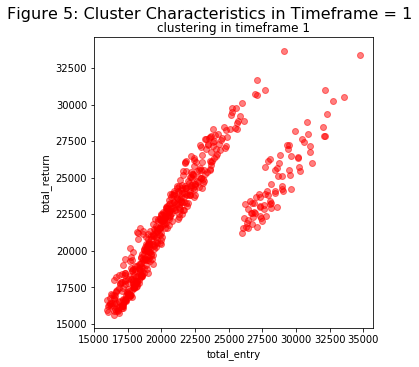

In [ ]:
visualize_timeframe1_clusters_with_xy(
    normal_results, "Figure 5: Cluster Characteristics in Timeframe = 1", "total_entry", "total_return")

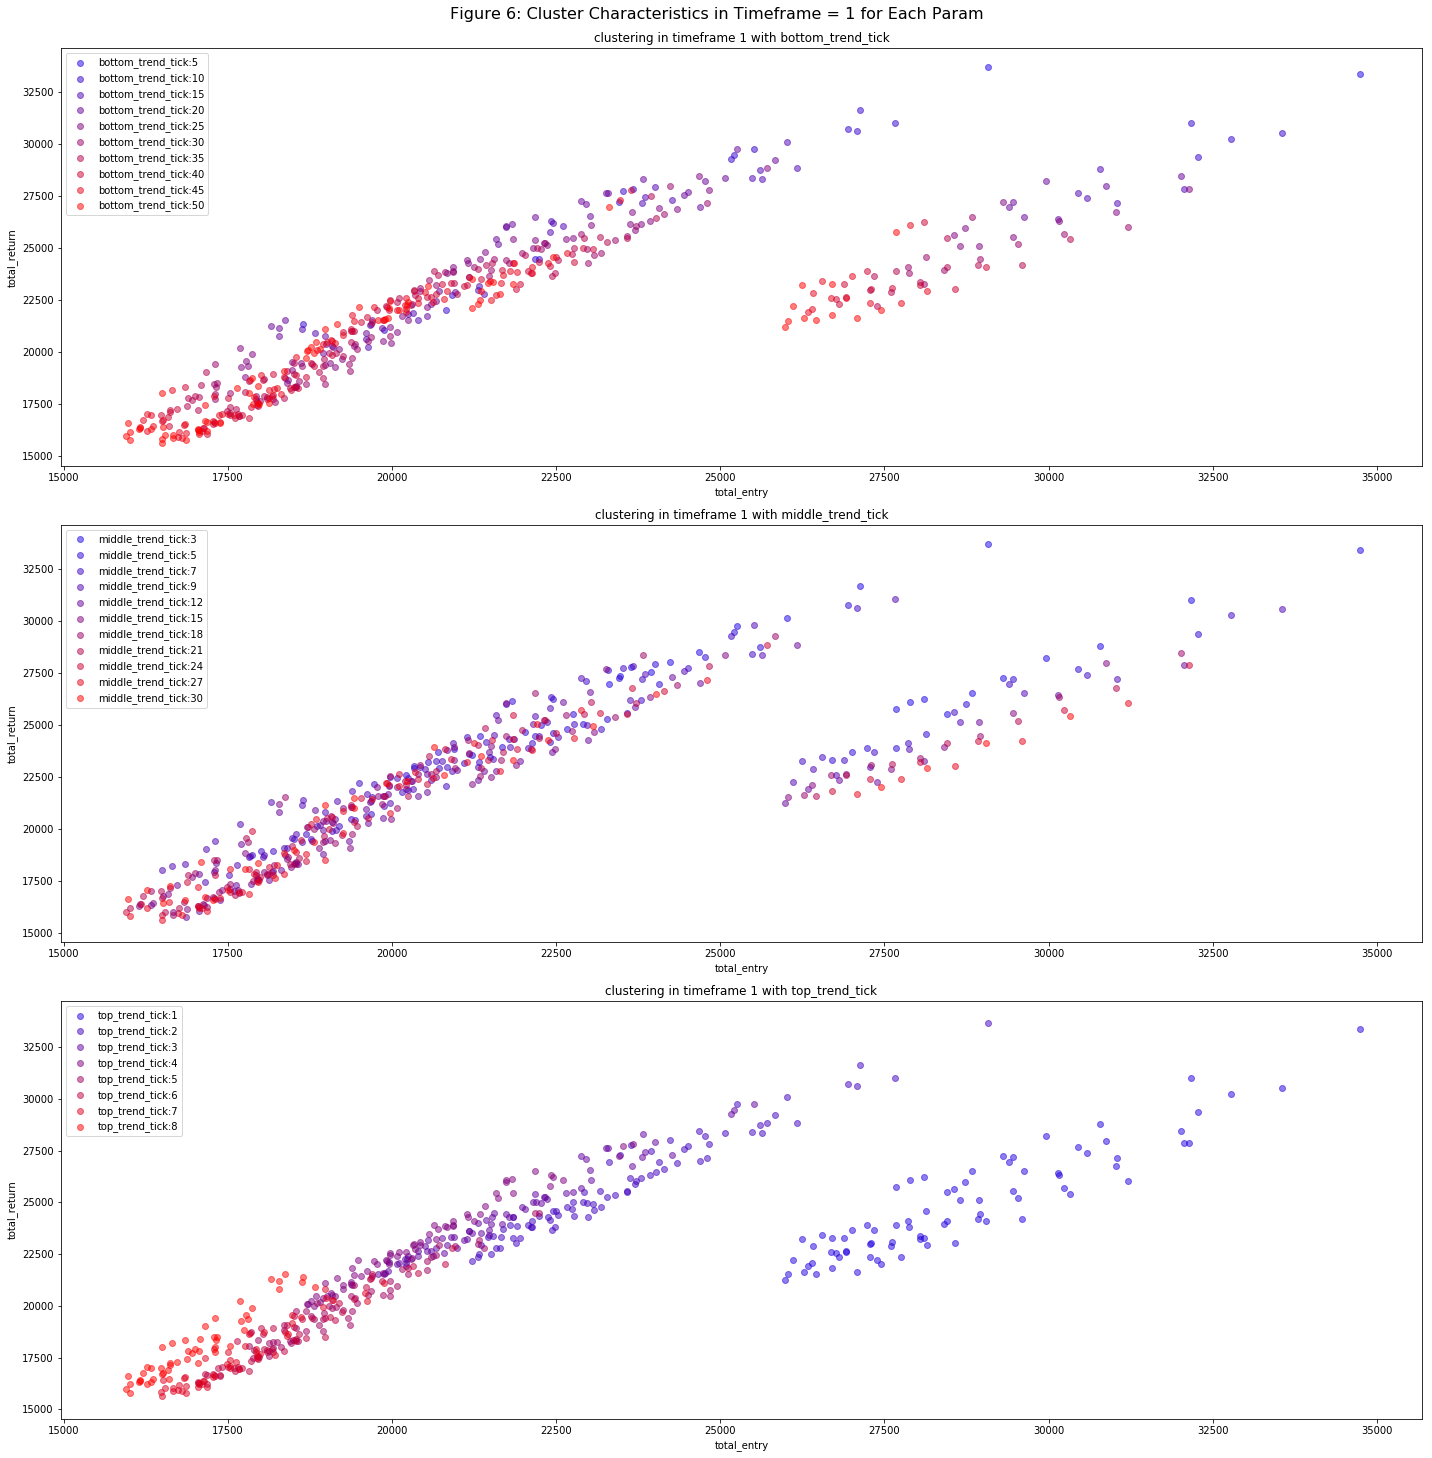

In [ ]:
visualize_timeframe1_clusters_with_xy_for_each_param(
    normal_results, "Figure 6: Cluster Characteristics in Timeframe = 1 for Each Param",
    "total_entry", "total_return")

見たところではこの集団を大きく分けるのはtop trend tickが考えられそうである。そこでtop trend tickが1,2,3の場合を抽出する。

tick_param:1
intercept : [-9633.80923382]
coefficient : [[1.20309827]]
R-squared : 0.8499991682105521
tick_param:2
intercept : [-7870.87920557]
coefficient : [[1.43667523]]
R-squared : 0.9528787079827928
tick_param:3
intercept : [-7730.88324476]
coefficient : [[1.47884041]]
R-squared : 0.9689679689678766


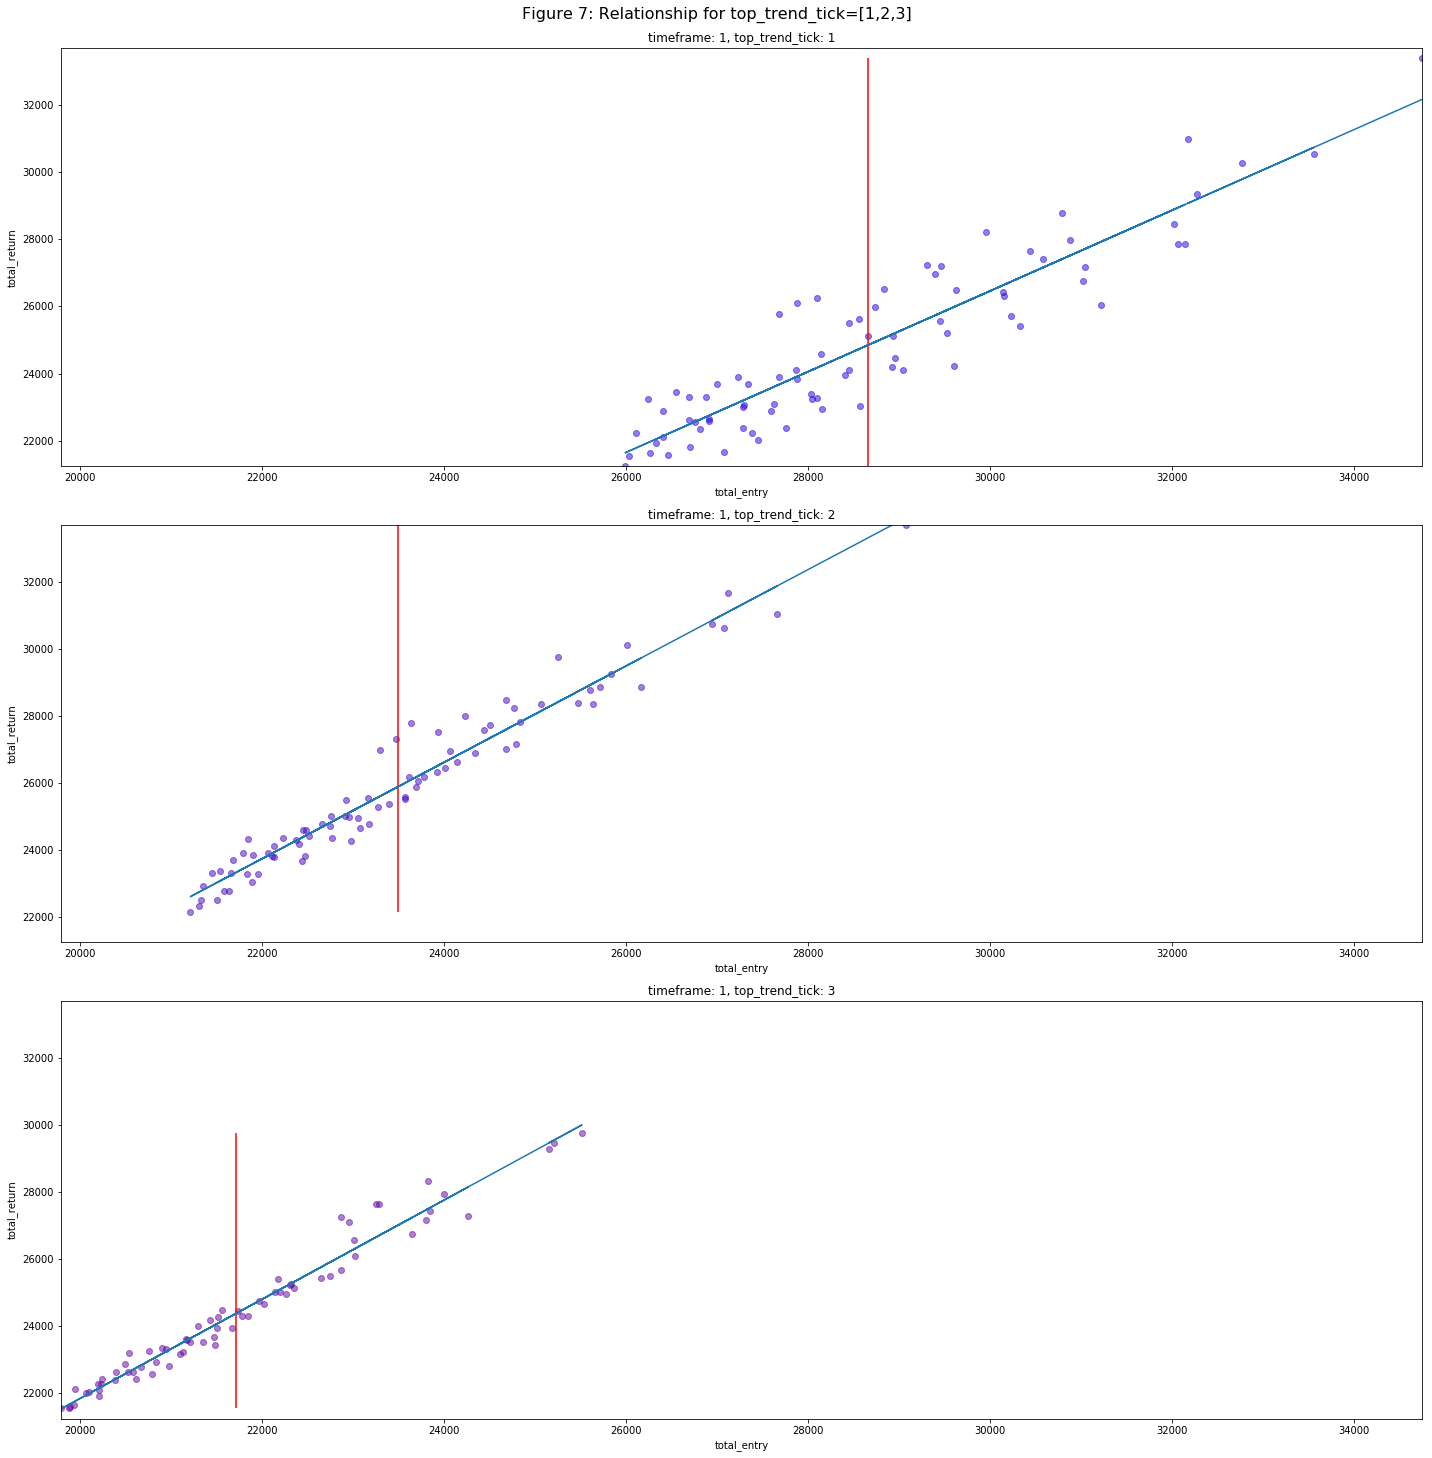

In [ ]:
pickup_top_tick_with_xy(normal_results, "Figure 7: Relationship for top_trend_tick=[1,2,3]", [1,2,3] ,
                "total_entry", "total_return", True)

top trendが1,2,3の場合を抽出した。また同時に単回帰直線を引いた。
青い線は単回帰直線、赤い線は平均を示している。

回帰直線の結果を

tick_param:1
intercept : [-0.0684051]
coefficient : [[0.04487919]]
R-squared : 0.5898971844422924
tick_param:2
intercept : [0.99313894]
coefficient : [[0.01514564]]
R-squared : 0.05668736276246711
tick_param:3
intercept : [0.63179475]
coefficient : [[0.02569279]]
R-squared : 0.38030126607995346
tick_param:4
intercept : [0.44059266]
coefficient : [[0.03055897]]
R-squared : 0.2756371375936324
tick_param:5
intercept : [0.93066277]
coefficient : [[0.01493506]]
R-squared : 0.0677807961886433
tick_param:6
intercept : [0.18255174]
coefficient : [[0.03544285]]
R-squared : 0.3870996687009918
tick_param:7
intercept : [0.77392156]
coefficient : [[0.01820983]]
R-squared : 0.1380791828256751
tick_param:8
intercept : [0.33665076]
coefficient : [[0.03110587]]
R-squared : 0.26949123471126313


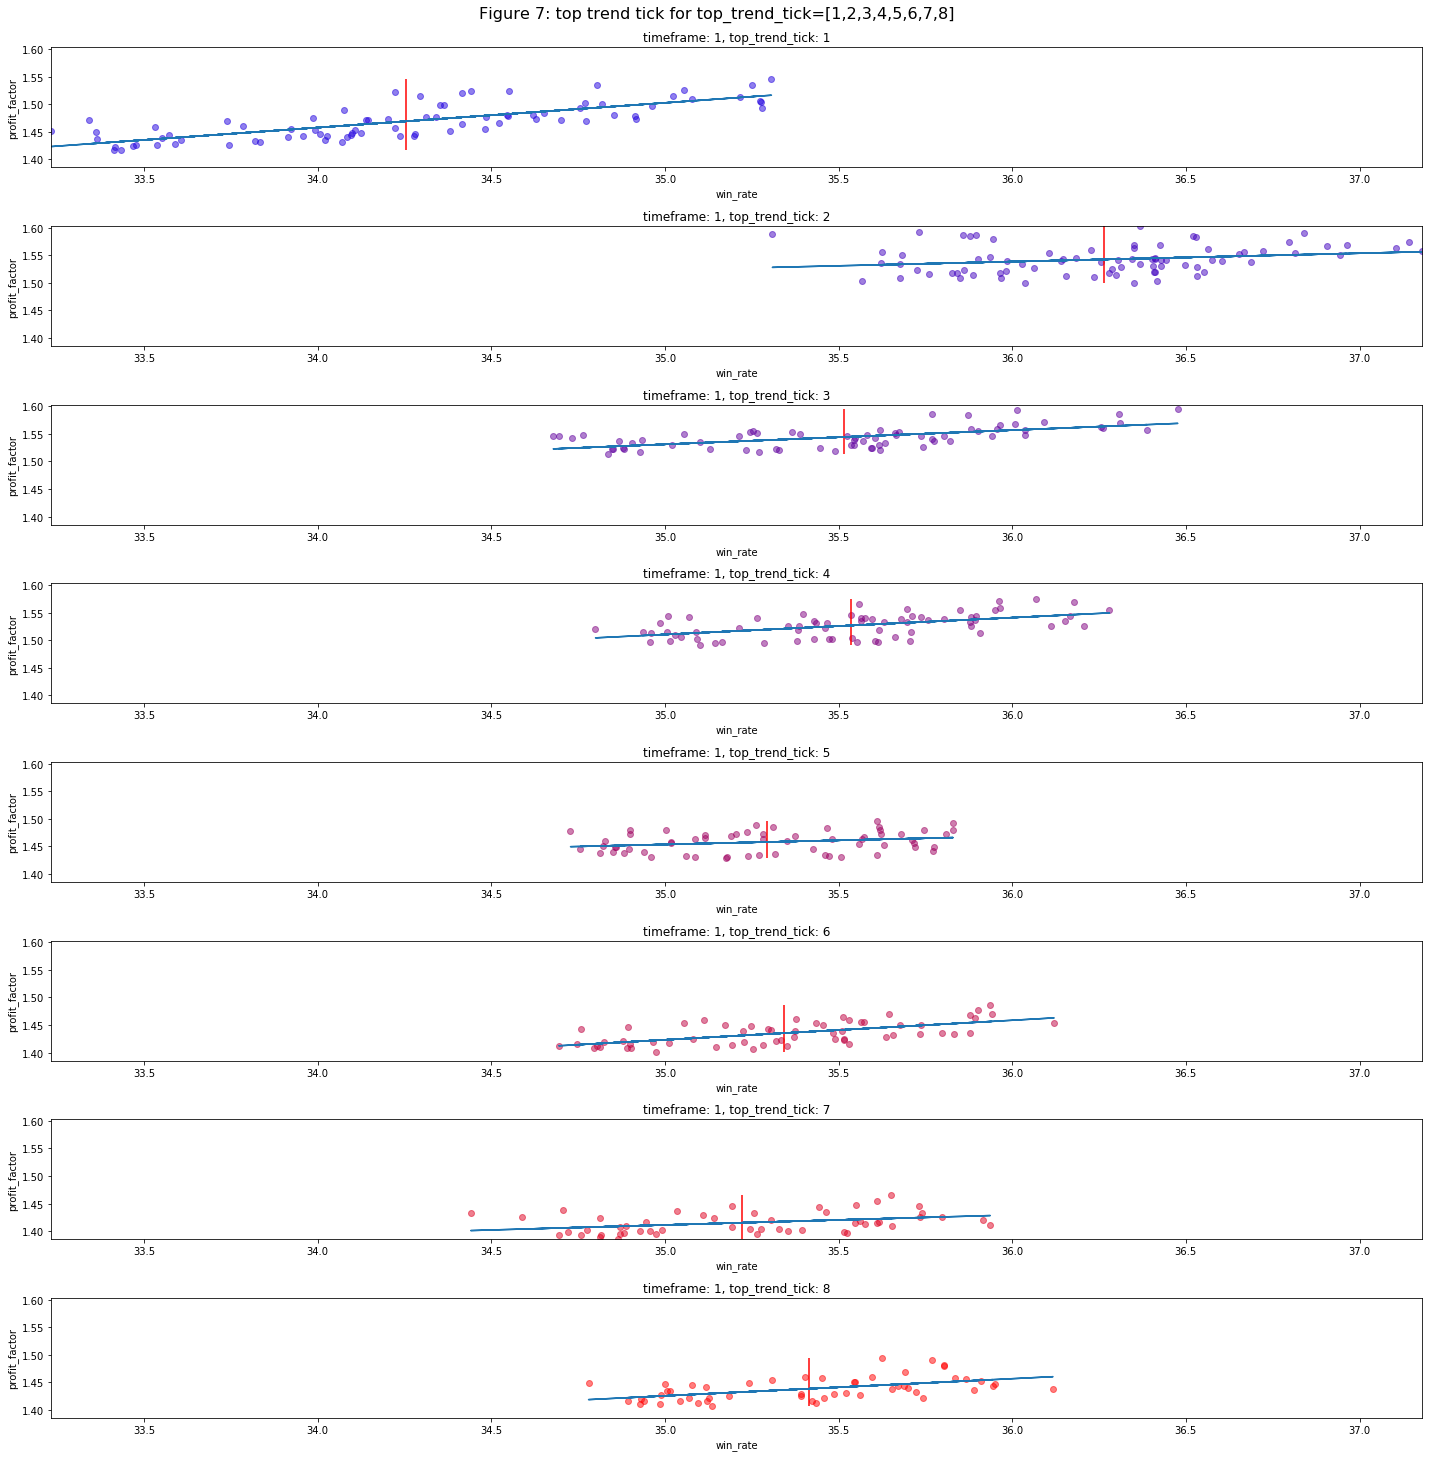

In [ ]:
pickup_top_tick_with_xy(normal_results, "Figure 7: top trend tick for top_trend_tick=[1,2,3,4,5,6,7,8]", [1,2,3,4,5,6,7,8] ,
                        "win_rate", "profit_factor", True)

違いがとても明瞭になった。
top trend tickがエントリ回数に重要な役割を果たしていて、それが短ければ短い程多くエントリし、エントリ回数がtotal returnに直結している。
一応top trend tick=1のクラスタに対して正則化を施した回帰直線を引いてみる。

In [ ]:
def draw_asset_curve(dataframe, percentile, reverse_ranking=False, title="cumulative asset curves"):
    if reverse_ranking:
        reversed_df = dataframe.sort_values("profit_factor", ascending=True)
        top_n_percentile = reversed_df.query(str(reversed_df.quantile(percentile).profit_factor) + " > profit_factor")
    else:        
        top_n_percentile = dataframe.query(str(dataframe.quantile(percentile).profit_factor) + " < profit_factor")
    figure_width = 1
    figure_height = len(top_n_percentile)/figure_width + 1
    
    figure_nums = len(top_n_percentile)
    
    asset_figure = rk.plt.figure()
    asset_figure.suptitle("cumulative asset curve", fontsize=16, y=1.01)
    asset_figure.subplots_adjust(wspace=0.4, hspace=0.6)
    
    for i, row in enumerate(top_n_percentile.itertuples()):
        summary_model_obj = rk.mysql_client.session.query(BacktestSummary).filter(BacktestSummary.id==row.backtest_summary_id).all()[0]
        transaction_log_df = rk.mysql_client.model_to_dataframe(summary_model_obj.backtest_transaction_log)
        graph = asset_figure.add_subplot(figure_height,figure_width,i+1)
        graph.set_title("cumulative asset curve id:" + str(row.Index) + " (bottom:" + str(row.bottom_trend_tick) + ", middle:" +\
                       str(row.middle_trend_tick) + ", top:" + str(row.top_trend_tick) + ", timeframe:" +\
                       str(row.timeframe))
        graph.set_xlabel("time")
        graph.set_ylabel("asset USD")
        graph.plot(a.close_time, a.current_balance)
        
    asset_figure.tight_layout()
    rk.plt.rcParams['figure.figsize'] = (13.0, 13.0)
        
#draw_asset_curve(normal_results, 0.99)
#draw_asset_curve(inversed_results, 0.99)
    

In [ ]:
def generate_summary_by_id(summary_id):
    from model.backtest_summary import BacktestSummary
    from model.backtest_management import BacktestManagement
    
    summary_model_obj = rk.mysql_client.session.query(BacktestSummary).filter(BacktestSummary.id==summary_id).all()[0]
    
    summary_df = rk.mysql_client.model_to_dataframe([summary_model_obj]).iloc[0,:]
    
    params_df = rk.mysql_client.get_row_by_backtest_summary_id("bottom_trend_follow_backtest_management", summary_id).iloc[0,:]
    
    transaction_log_df = rk.mysql_client.model_to_dataframe(summary_model_obj.backtest_transaction_log)
    print(params_df)
    print(summary_df)
    
    
    asset_figure = rk.plt.figure()
    graph = asset_figure.add_subplot(111)
    graph.set_title("cumulative asset curve id:" + str(summary_id) + " (bottom:" + str(params_df.bottom_trend_tick) + ", middle:" +\
        str(params_df.middle_trend_tick) + ", top:" + str(params_df.top_trend_tick) + ", timeframe:" +\
        str(params_df.timeframe))
    graph.set_xlabel("time")
    graph.set_ylabel("asset USD")
    graph.plot(transaction_log_df.close_time, transaction_log_df.current_balance)
    

best_summary_id = 1579
generate_summary_by_id(best_summary_id)

## Findings from searching optimal parameters

当初これはトレンドフォロー型のbotで、長期で大きく勝つことで高い収益をもたらすという先入観があった。
しかし結果を見るとこのbotは1分足で、しかも短期で頻繁に売買することで利益を上げるスキャルピングに強いことがわかった。
またパラメータも、小さければ小さいほど良いことが傾向として示された。

最終的には1分足でbottom tickは5, middle tickは3, top tickは1の場合が最適であるという結論を得た。

そこで次はどのような時に負けるか、どのような時に勝つのかを分析して、このbotの収益性を高める戦略の緒を探す。
そのためにはマーケットの指標としてテクニカル指標を導入する。

具体的には、このテストで使ったOHLCVデータに対してテクニカル指標を追加し、それを取引ログに結合することで、勝ちトレードと負けトレードがどのような時に発生しているのかという傾向を探る。MACDについては、価格そのものに意味は薄いのでその変化率をみる。

また、勝ちおよび負けトレードが予測可能かどうかも探る。これは最初の80日をtrainに、そして残りの10日をtestに分割し、その予測精度としてRMSEの大きさを計測する。

この問題は2値分類問題であり、これが可能であるならば勝てそうなトレードに多く賭ける、負けそうなトレードには小さく賭けるor何も賭けないという普遍的な改善策を取ることができる。

ここでは一旦ロジスティック回帰と、後にRNNを試すことにする。

In [ ]:
# datasets used in backtest
backtest_start_time = rk.datetime(2019,9,30,11,49)
backtest_end_time = rk.datetime(2019,12,29,11,49)
    
ohlcv_df_1min = rk.dataset_manager.get_ohlcv(start_time=backtest_start_time, end_time=backtest_end_time)

print(len(ohlcv_df_1min))

In [ ]:
from model.backtest_summary import BacktestSummary
def add_technical_statistics_to_ohlcv_df(df):
    from technical_analysis.ad import TechnicalAnalysisAD
    from technical_analysis.atr import TechnicalAnalysisATR
    from technical_analysis.bollinger_band import TechnicalAnalysisBB
    from technical_analysis.MACD import TechnicalAnalysisMACD
    from technical_analysis.SAR import TechnicalAnalysisSAR
    
    ta_ad = TechnicalAnalysisAD(df)
    ad_df = ta_ad.get_ad()

    ta_atr = TechnicalAnalysisATR(df)
    atr_df = ta_atr.get_atr()

    ta_sar = TechnicalAnalysisSAR(df)
    sar_df = ta_sar.get_psar_trend()

    ta_macd = TechnicalAnalysisMACD(df)
    macd_tick = [5,3,1]
    # already append these 3 cols
    ema_5 = ta_macd.append_ema_close(5)
    ema_3 = ta_macd.append_ema_close(3)
    ema_1 = ta_macd.append_ema_close(1)

    ta_applied = rk.pd.concat([df, ad_df, atr_df], axis=1)
    ta_applied.dropna(inplace=True)

    return ta_applied

ohlcv_with_ta = add_technical_statistics_to_ohlcv_df(ohlcv_df_1min)

pickup_time = rk.datetime(2019,12,29,8)
end_time = rk.datetime(2019,12,30)

picked_df = ohlcv_with_ta[pickup_time:end_time]

def get_transaction_logs_by_summary_id(summary_id):
    summary_model_obj = rk.mysql_client.session.query(BacktestSummary).filter(BacktestSummary.id==summary_id).all()[0]
    transaction_log_df = rk.mysql_client.model_to_dataframe(summary_model_obj.backtest_transaction_log)
    return transaction_log_df

transaction_log_df = get_transaction_logs_by_summary_id(best_summary_id) # 1579

picked_transaction_log_df = transaction_log_df[transaction_log_df.entry_time > pickup_time]
win_picked = picked_transaction_log_df[transaction_log_df.profit_status == "win"]
lose_picked = picked_transaction_log_df[transaction_log_df.profit_status == "lose"]

entry_times = list(picked_transaction_log_df.entry_time)

win_close_times = list(win_picked.close_time)
lose_close_times = list(lose_picked.close_time)

rk.plt.rcParams['figure.figsize'] = (30.0, 10.0)
rk.plt.plot(picked_df.index, picked_df.close)
rk.plt.plot(picked_df.index, picked_df.ema_5)
rk.plt.plot(picked_df.index, picked_df.ema_3)
rk.plt.plot(picked_df.index, picked_df.ema_1)
rk.plt.ylim(7275, 7320)
rk.plt.vlines(entry_times, ymin=7000, ymax=8000, color="black")
rk.plt.vlines(win_close_times, ymin=7000, ymax=8000, color="red")
rk.plt.vlines(lose_close_times, ymin=7000, ymax=8000, color="blue")
rk.plt.plot()

黒のラインがエントリーポイント。赤のラインが勝利、青のラインが敗北。
最後の取引を見るとレンジ相場に弱そうである。
ところどころトレンド相場で負けているのも気になるところ。
勝ちトレードの平均取引時間が長いことも見て取れる。
また低い勝率ながら大き目の勝ちを重ねていることもわかる。

レンジ相場に入る直前の勝率が高そうな感じがする。
勝っているトレンド相場と負けているトレンド相場の違いも気になる。

In [ ]:
win_transaction_log = transaction_log_df[transaction_log_df.profit_status == "win"]
lose_transaction_log = transaction_log_df[transaction_log_df.profit_status == "lose"]

win_merged = rk.pd.merge(win_transaction_log, ohlcv_with_ta, left_on="close_time", right_on=ohlcv_with_ta.index)
lose_merged = rk.pd.merge(lose_transaction_log, ohlcv_with_ta, left_on="close_time", right_on=ohlcv_with_ta.index)
   
def create_hist(win_data, lose_data, focus_factor=""):
    win = win_merged[focus_factor]
    lose = lose_merged[focus_factor]
    
    bins = 200
    
    figure = rk.plt.figure()
    figure.suptitle(focus_factor + " between win and lose")
    
    for i, win_lose in enumerate(["win", "lose"]):
        graph = figure.add_subplot(1,2,1+i)
        if win_lose == "win":
            graph.hist(win, bins=bins)
        else:
            graph.hist(lose, bins=bins)
        graph.set_title( focus_factor + " on " + win_lose)
        graph.set_xlabel(focus_factor)
        graph.set_ylabel("freq")
        
    rk.plt.show()
        
    win_mean = win_merged[focus_factor].mean()
    lose_mean = lose_merged[focus_factor].mean()
    print("win " + focus_factor + " mean => " + str(win_mean))
    print("lose " + focus_factor + " mean => " + str(lose_mean))
    
    win_std = win_merged[focus_factor].std()
    lose_std = lose_merged[focus_factor].std()
    print("win " + focus_factor + " standard deviation => " + str(win_std))
    print("lose " + focus_factor + " standard deviation => " + str(lose_std))
    
    win_med = win_merged[focus_factor].median()
    lose_med = lose_merged[focus_factor].median()
    print("win " + focus_factor + " median => " + str(win_med))
    print("lose " + focus_factor + " median => " + str(lose_med))
    

    
def win_lose_stat(win_merged, lose_merged):
    # price difference
    create_hist(win_merged, lose_merged, "price_difference")
    create_hist(win_merged, lose_merged, "psar")
    create_hist(win_merged, lose_merged, "ad")
    create_hist(win_merged, lose_merged, "atr")
    
print(list(win_merged.columns))
    
win_lose_stat(win_merged, lose_merged)



In [ ]:
win_long = win_merged[win_merged.order_type == "long"]
win_short = win_merged[win_merged.order_type == "short"]

win_long_cond = len(win_long) / len(win_merged)
win_short_cond = len(win_short) / len(win_merged)

print("long propotion on win => " + str(win_long_cond))
print("short propotion on win => " + str(win_short_cond))

lose_long = lose_merged[lose_merged.order_type == "long"]
lose_short = lose_merged[lose_merged.order_type == "short"]

lose_long_cond = len(lose_long) / len(lose_merged)
lose_short_cond = len(lose_short) / len(lose_merged)

print("\n")
print("long propotion on lose => " + str(lose_long_cond))
print("short propotion on lose => " + str(lose_short_cond))

見たところこれらの指標において勝ちトレードと負けトレードの差はあまりなさそうである。

### price difference
勝ちの値幅の変動がマイナスであること、負けの値幅の変動がマイナスである。
勝ちの値幅の標準偏差が負けに比べて非常に大きい。

勝っているときの値幅の変動がマイナスであることから、勝ちトレードにショートが多いと予想した。
結果は予想通りだったが、負けトレードにおけるショートの割合はさらに多かった。
ここにおいてはハイリスクハイリターンの関係が成立している。

### psar
標準偏差はどちらの場合も大きく、平均も大きな差があるようには見えない。

グラフからは大きく3つの山が存在していることが確認できる。
左から順々に小さくなっていることがわかる。
この3つの山は3種類の状態が存在することを意味しているのかもしれない。

[MT5のページ](https://www.metatrader5.com/ja/terminal/help/indicators/trend_indicators/psar)によるとpsarにはトレンド相場がブルであるかベアであるかを検出することができるそうだ。
そこから考えると、トレンド相場のうちのブル相場、ベア相場、レンジ相場がこの3つの山に対応していそうである。
しかしそれ以外の可能性として、3ヶ月の値動きの、それぞれの月の平均的な位置がこの3つの山の中心にあることが挙げられる。
また、もしその3つの相転移が存在するならば、負けトレードにもブル、ベア、レンジの3つの山ができるのは、ブル、ベアのトレンド相場に強いbotの特性からすると妙である。

PSARはジャンプを特徴としている。この値がジャンプした際にはトレンドの転換、すなわち相転移の発生を検出する。

uptrend、すなわちbullかとdowntrend、すなわちbearかはpsar_trendの値を見るとわかる。
ここでの問題はuptrendとdowntrendが2つの値しか取らないことである。
つまり原理的にPSARの返り値にはレンジ相場が存在しない。

ただPSARの返り値はbottom trend followのbotに対して相性が良さそうだ。
より具体的には取引回数、頻度をそこまで下げることなく勝率を向上させることができそうだ。

### ad
標準偏差はどちらの場合も大きく、平均も大きな差があるようには見えない。

[このページ](https://xn--hck6a9a3a3cl0j7al2328j687d.com/?p=4932)がADラインの説明としてわかりやすい。
この指標はダイバージェンスを検出する指標として使われる。もっぱら逆張りの用途で使われるようだが、逆に言えばこのダイバージェンスが起きていないときはトレンド相場が続くと判断することが可能になる。

またbitcoinの価格の変動が大きいということはつまり安定していないということであり、安定していないならば値が上がるか下がるかのみである。
このグラフにはうっすらと2つの山が見えているが、これは値が上がるか下がるか、つまりブル相場かベア相場かの2種類の状態を表していると
推測することができる。

### ATR
標準偏差はどちらの場合も大きく、平均も大きな差があるようには見えない。

だがこの指標の特徴として高値-安値なので0以上の値のみしかとらないという点がある。
[ATRの説明はこちら](http://www.avatrade.co.jp/kojiro/13/)が詳しい。
ATRが増大している時はトレンド相場、ATRが縮小しているときはレンジ相場である。

それを鑑みると、勝ちトレードのATRが負けトレードのATRに比べて大きい傾向があることから、トレンドフォロー型botの特性を備えていると言える可能性がある。